# Plotting using the "low-level" interface

In the last two notebooks I've created, I've shown how to create a user model (using `add_model` rather than `load_user_model`) and use the "low-level" interface$^\dagger$ to fit a data set (that is, without using the routines in `sherpa.ui` or `sherpa.astro.ui`). One thing I haven't done is show how to create plots when using the "low-level" interface, so I thought I'd show how here.

The previous notebooks, which probably need to be skimmed for the following to make any sense, are:

1. [User models in Sherpa](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/user%20model.ipynb)
2. [Writing an "integrated" user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/an%20integrated%20user%20model.ipynb)

$^\dagger$ we haven't come up with a better name for this API yet.

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on June 5 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository
if you have any questions. 

## Follow up

The notebook has been updated to reflect changes in Sherpa.

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2024-01-02 11:33'

In [2]:
import sherpa
sherpa.__version__

'4.16.0'

## What data am I using again?

Let's start with the data set I've been using recently:

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
rng = np.random.default_rng(1)
k_orig = 1.1
theta_orig = 2.6
ysim = stats.gamma.rvs(a=k_orig, scale=theta_orig, size=1000, random_state=rng)

I am going to concentrate on the "CDF" version of the data, but will also use the "PDF" version to show how to plot `Data1DInt` data sets. The "CDF" refers to the cumulative distribution function and "PDF" the probability density function.

In [5]:
xcdf = ysim.copy()
xcdf.sort()
ycdf = np.arange(1, xcdf.size+1) * 1.0 / xcdf.size

In [6]:
(ypdf, edges) = np.histogram(ysim, bins=31, density=False)
xlo = edges[:-1]
xhi = edges[1:]

The data is stored in objects; here the `Data1D` and `Data1DInt` classes:

In [7]:
from sherpa.data import Data1D, Data1DInt

dcdf = Data1D('cdf', xcdf, ycdf)
dpdf = Data1DInt('pdf', xlo, xhi, ypdf)

We can take advantage of the new support in Sherpa 4.12.2 that can display objects directly in Jupyter notebooks:

In [8]:
dcdf

<Data1D data set instance 'cdf'>

In [9]:
dpdf

<Data1DInt data set instance 'pdf'>

## Plotting data

To plot these, I need the `DataPlot` class:

In [10]:
from sherpa.plot import DataPlot

A `DataPlot` object is given the data to plot via the `prepare` method, and then actually plotted with the `plot` method. Note that `prepare` takes an optional statistics object, which is used to determine how to estimate error bars if none are given explicitly. For this example I do not want any error bars, so leave it at its default.

In [11]:
plotcdf = DataPlot()
plotcdf.prepare(dcdf)

With all this I can create a plot of the data:

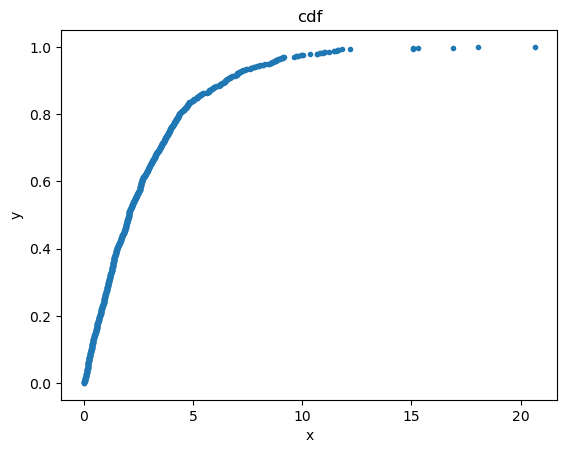

In [12]:
plotcdf.plot()

Normal `matplotlib` commands can be used to adjust the display; for instance, to increase the Y range to better show the behavior of the data at large `x`:

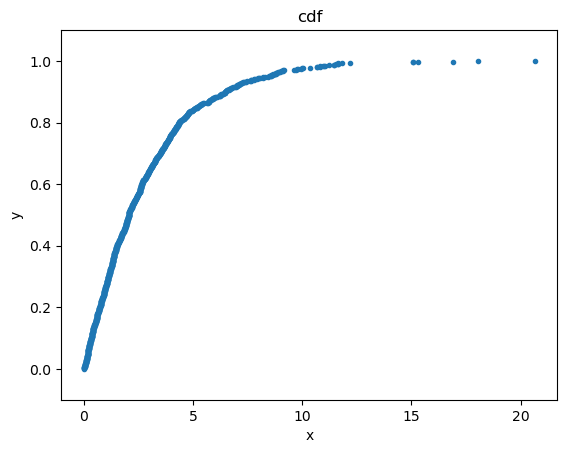

In [13]:
plotcdf.plot()
plt.ylim(-0.1, 1.1);

The approach for the "binned" data set is the same: call `prepare` and then `plot`. However, new in Sherpa 4.12.2, is the addition of
a separate plot class for histogram data. I also change the preferences for the plot - `histo_prefs` is a dictionary - so that the Y axis is drawn in a log scale:

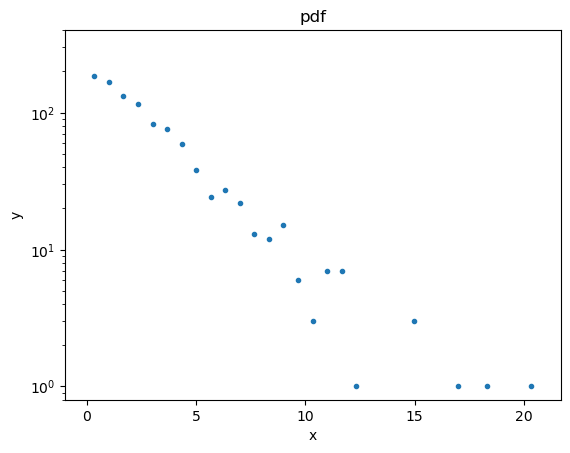

In [14]:
from sherpa.plot import DataHistogramPlot

plotpdf = DataHistogramPlot()
plotpdf.prepare(dpdf)
plotpdf.histo_prefs['ylog'] = True
plotpdf.plot()
plt.ylim(0.8, 400);

## Setting up the models

I use the same models as in the previous notebooks, but this time I cut out the documentation, to save space. Note that as I'm using the low-level interface I do not need to call `add_model` to use either the `GammaCDF` or `GammaPDF` models.

In [15]:
from sherpa import utils
from sherpa.models import model
from sherpa.models.parameter import tinyval

In [16]:
def calc_gamma_cdf(x, k, theta):
    tval = theta * 1.0
    kval = k * 1.0
    x = np.asarray(x)
    out = np.zeros_like(x)
    for i,xi in enumerate(x):
        out[i] = utils.igam(kval, xi/tval)

    return out

def calc_gamma_pdf(x, k, theta):
    tval = theta * 1.0
    kval = k * 1.0
    norm = utils.gamma(kval) * theta**kval
    return x**(kval-1.0) * np.exp(-x / tval) / norm

def calc_gamma_pdf_int(xlo, xhi, k, theta):
    return calc_gamma_cdf(xhi, k, theta) - calc_gamma_cdf(xlo, k, theta)

In [17]:
class GammaCDF(model.ArithmeticModel):
    """A Gamma CDF."""

    ndim = 1
    
    def __init__(self, name='gammacdf'):
        self.k = model.Parameter(name, 'k', 5, min=tinyval, hard_min=0)
        self.theta = model.Parameter(name, 'theta', 2, min=tinyval, hard_min=0)

        model.ArithmeticModel.__init__(self, name, (self.k, self.theta))

    @model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta) = pars
        if len(args) == 1:
            x = (x + args[0]) / 2.0

        return calc_gamma_cdf(x, k, theta)
        
class GammaPDF(model.ArithmeticModel):
    """A Gamma PDF."""

    ndim = 1
    
    def __init__(self, name='gammapdf'):
        self.k = model.Parameter(name, 'k', 5, min=tinyval, hard_min=0)
        self.theta = model.Parameter(name, 'theta', 2, min=tinyval, hard_min=0)
        self.norm = model.Parameter(name, 'norm', 1, min=0) # allow -ve if they realy want it
        
        model.ArithmeticModel.__init__(self, name, (self.k, self.theta, self.norm))

    @model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta, norm) = pars
        if len(args) == 0:
            return norm * calc_gamma_pdf(x, k, theta)
        elif len(args) == 1:
            return norm * calc_gamma_pdf_int(x, args[0], k, theta)
        else:
            raise ValueError("Expected x or xlo/xhi grid.")
            
    def guess(self, dep, *args, **kwargs):
        norm = dep.sum()
        self.norm.val = dep.sum()
        self.norm.frozen = True

## Plotting models

To plot a model, I need an instance of the model to plot (in this case it's just a single component, but it could be some more-complicated expression).

In [18]:
mcdf = GammaCDF('cdf')
mpdf = GammaPDF('pdf')

In [19]:
from sherpa.plot import ModelPlot

The approach is similar to the data case: create an instance of the `ModelPlot` class, call `prepare` and then `plot`. The difference here is that `prepare` needs both the data set (to know what the independent axis is) and the model expression.

In [20]:
mplotcdf = ModelPlot()

The help for the method is not particularly illuminating - it is on our list of things to improve! - but at least the argument names are somewhat meaningful! 

In [21]:
help(mplotcdf.prepare)

Help on method prepare in module sherpa.plot:

prepare(data, model, stat=None) method of sherpa.plot.ModelPlot instance
    Create the data to plot
    
    Parameters
    ----------
    data
        The Sherpa data object to display (it is assumed to be
        one dimensional). This defines the grid over which the
        model is displayed.
    model
        The Sherpa model expression to evaluate and display.
    stat : optional
        This parameter is unused.
    
    See Also
    --------
    plot



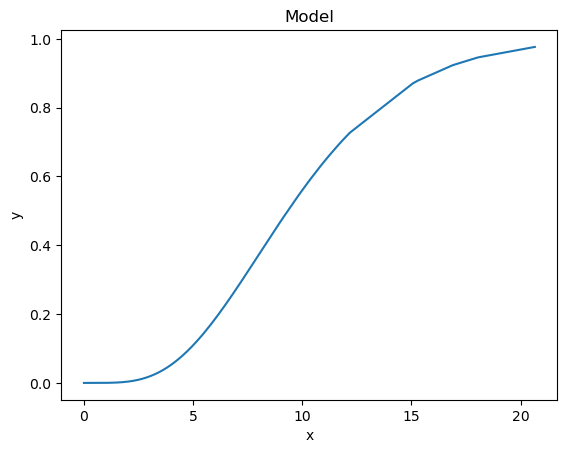

In [22]:
mplotcdf.prepare(dcdf, mcdf)
mplotcdf.plot()

Now, the `plot` method also accepts optional arguments, and I am going to take advantage of `overplot` to combine the data with the model:

In [23]:
help(mplotcdf.plot)

Help on method plot in module sherpa.plot:

plot(overplot=False, clearwindow=True, **kwargs) method of sherpa.plot.ModelPlot instance
    Plot the data.
    
    This will plot the data sent to the prepare method.
    
    Parameters
    ----------
    overplot : bool, optional
       If `True` then add the data to an existing plot, otherwise
       create a new plot.
    clearwindow : bool, optional
       Should the existing plot area be cleared before creating this
       new plot (e.g. for multi-panel plots)?
    **kwargs
       These values are passed on to the plot backend, and must
       match the names of the keys of the object's
       plot_prefs dictionary.
    
    See Also
    --------
    prepare, overplot



Using this we can see that the current set of model parameters is *not* a good fit to the data!

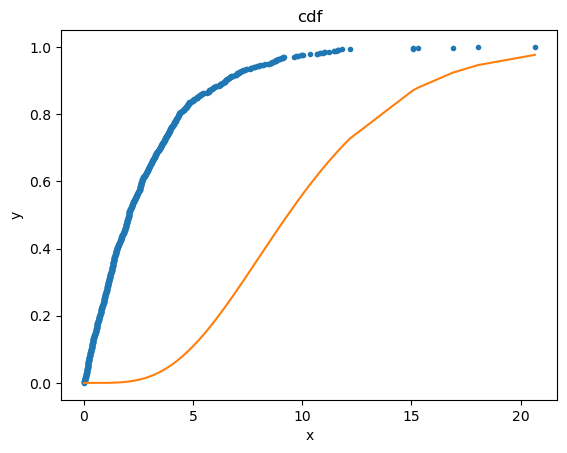

In [24]:
plotcdf.plot()
mplotcdf.plot(overplot=True)
plt.ylim(-0.05, 1.05);

The above plot may also look a bit like the output of the `sherpa.ui.plot_fit` command, which is not-too surprising as it essentially is! I'll show below how the "fit"-style plot is created if you do not want to do it manually, like this.

A number of Sherpa classes, in particular the plot classes, support rich display in a notebook environment. For instance, if the `prepare` method has been called then we can display the plot data just by saying the following (but note this does not support setting attributes in the `plot` call like `overplot` or `alpha`):

In [25]:
plotcdf

However, before worrying about fits, I'd like to just repeat the above for the "pdf" data set, since it is binned ("integrated" in Sherpa parlance). Note that 

- I have had to use a different model-plot object to support the histogram nature of the data;
- it uses a log scale for Y axis due to the settings of `dpdf`.

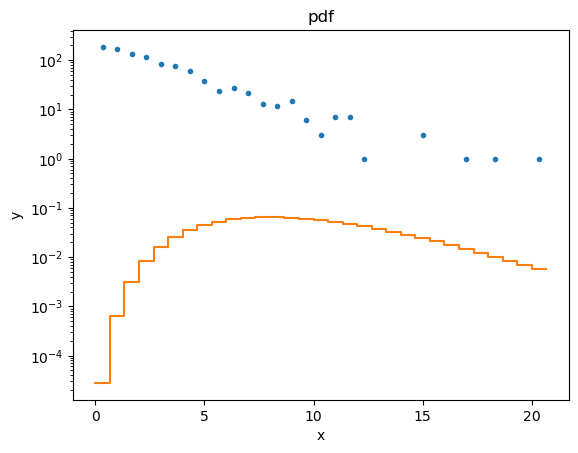

In [26]:
from sherpa.plot import ModelHistogramPlot

mplotpdf = ModelHistogramPlot()
mplotpdf.prepare(dpdf, mpdf)
plotpdf.plot()
mplotpdf.plot(overplot=True)

## Fitting the data

To look at fit results, I want to first fit the data (so that the models are a better approximation to the data). For this we need the `Fit` object. I am not going to explain this in depth since it is a repeat of the previous two notebooks, and I really just need this
done so that the models can be plotted!

In [27]:
from sherpa.optmethods import LevMar, NelderMead
from sherpa.stats import Cash, LeastSq
from sherpa.fit import Fit

For the CDF data, for which I am going to use a least-square statistic, I use the "default" Sherpa optimiser, which is the `LevMar` class. For the PDF data set, which I am using a Maximum Likelihood estimator, I use `NelderMead` (which is the Nelder-Mead Simplex algorithm), since, although it is often slower than `LevMar`, is less-likely to stop in a local minima (this is a statement of my experience, depends on the data and model being fit, and comes with no warranty).

When using the "standard" Sherpa UI for fitting data, only one optimiser and statistic can be in use at a time. This restriction does not hold here, since you have to be explicit in your choices!

In [28]:
fcdf = Fit(dcdf, mcdf, LeastSq(), LevMar())
fpdf = Fit(dpdf, mpdf, Cash(), NelderMead())

Note that creating a `Fit` object does *not* run the fit, so at this time the model parameters
are unchanged. The `Fit` class comes with some useful methods, such as calculating the statistic for the current model and data:

In [29]:
fcdf.calc_stat()

238.93586941729743

More context is provided by the `calc_stat_info` method:

In [30]:
print(fcdf.calc_stat_info())

name      = 
ids       = None
bkg_ids   = None
statname  = leastsq
statval   = 238.93586941729743
numpoints = 1000
dof       = 998
qval      = None
rstat     = None


In [31]:
print(fpdf.calc_stat_info())

name      = 
ids       = None
bkg_ids   = None
statname  = cash
statval   = 11725.158639582614
numpoints = 31
dof       = 28
qval      = None
rstat     = None


This is the same output as the `ui.calc_stat_info` routine returns, except that some concepts - such as data set ids - are not relevant here. As neither of the chosen statistics are based on (i.e. derived from) the Chi Square class (`sherpa.stats.Chi2`), the `qval` and `rstat` fields are not filled in.

So, what happens when the data is fit?

In [32]:
fcdf.fit()

Parameter,Best-fit value,Approximate error
cdf.k,1.12593,± 0.33594
cdf.theta,2.53022,± 0.997753


In [33]:
fpdf.fit()

Parameter,Best-fit value
pdf.k,1.11618
pdf.theta,2.55147
pdf.norm,1002.41


In [34]:
fcdf.calc_stat()

0.028403826316123718

In [35]:
fpdf.calc_stat()

-6922.653307548397

As can be seen, the fits have reduced the statistic value for both data sets. The model parameter values, or the return value of the `fit` call, can be viewed for more details, but let's look at the data.

## Looking at fit results

To display both model and data in the same plot, I could do it manually, as I did earlier, but I want to try out the `FitPlot` class:

In [36]:
from sherpa.plot import FitPlot

In [37]:
fplotcdf = FitPlot()

In [38]:
help(fplotcdf.prepare)

Help on method prepare in module sherpa.plot:

prepare(dataplot, modelplot) method of sherpa.plot.FitPlot instance
    Create the data to plot
    
    Parameters
    ----------
    dataplot
        The Sherpa plot object representing the data (normally a
        DataPlot instance).
    modelplot
        The Sherpa plot object representing the model (normally a
        ModelPlot instance).
    
    See Also
    --------
    plot



So, prepare takes "plot" objects, which are the `DataPlot` and `ModelPlot` instances I have already used. However, I need to "refresh" the model plot contents, since the model parameter values have changed (it may well be safer to always re-create these objects so you are sure what is being plotted, but for now I want to save some typing): 

In [39]:
mplotcdf.prepare(dcdf, mcdf)
fplotcdf.prepare(plotcdf, mplotcdf)

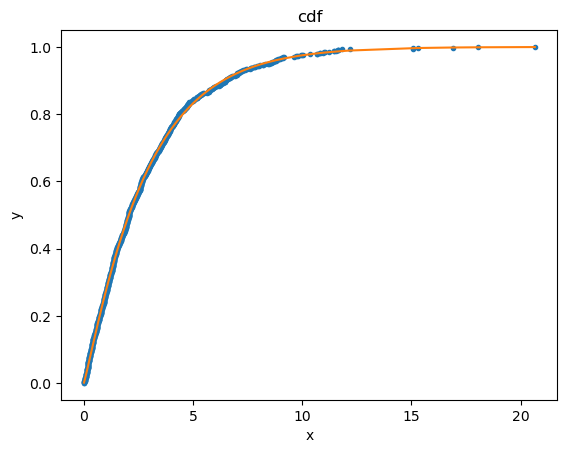

In [40]:
fplotcdf.plot()

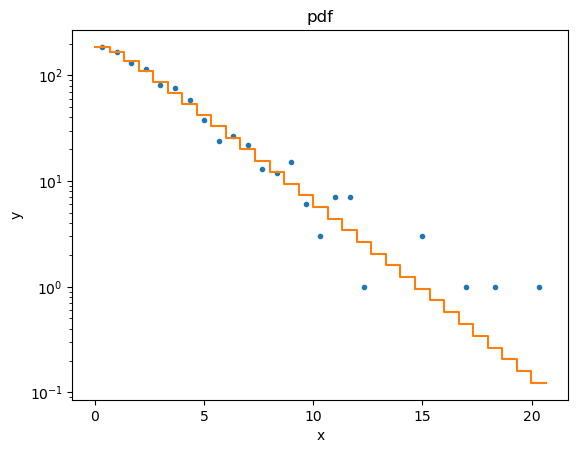

In [41]:
mplotpdf.prepare(dpdf, mpdf)
fplotpdf = FitPlot()
fplotpdf.prepare(plotpdf, mplotpdf)
fplotpdf.plot()

So, the fits have worked!

## How about the residuals

The residuals could be calculated directly from the `DataPlot` and `ModelPlot` instances, but Sherpa also provides a `ResidPlot` class (there's also `DelchiPlot` for when you want ``(data-model)/error``): 

In [42]:
from sherpa.plot import ResidPlot

In [43]:
rplotcdf = ResidPlot()

In [44]:
help(rplotcdf.prepare)

Help on method prepare in module sherpa.plot:

prepare(data, model, stat) method of sherpa.plot.ResidPlot instance
    Create the data to plot
    
    Parameters
    ----------
    data
        The Sherpa data object to display (it is assumed to be
        one dimensional). This defines the grid over which the
        model is displayed.
    model
        The Sherpa model expression to evaluate and display.
    stat : optional
        This parameter is unused.
    
    See Also
    --------
    plot



Unlike previous plots, the `stat` argument is not optional, so I use the same statistic as in the fit (but a different instance). This is only used for calculating the error bars, which I am going to turn off anyway, so the exact choice is unimportant.

In [45]:
rplotcdf.prepare(dcdf, mcdf, LeastSq())

With the plot prepared, can create it:

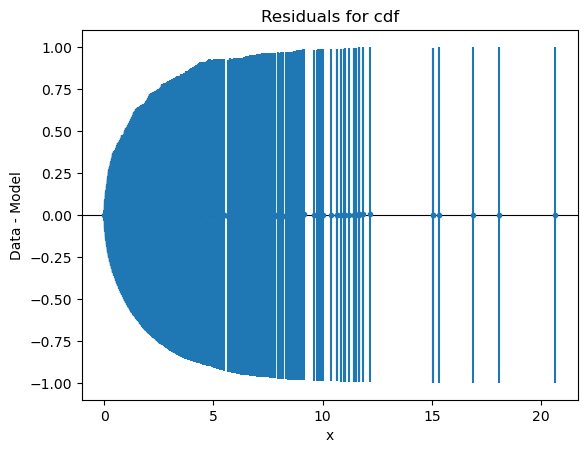

In [46]:
rplotcdf.plot()

As the defaults are not sensible here, I can change them by

 - turning off the error bars
 - use a line to connect the points rather than a symbol
   (I know the data is sorted, so a line works well here)

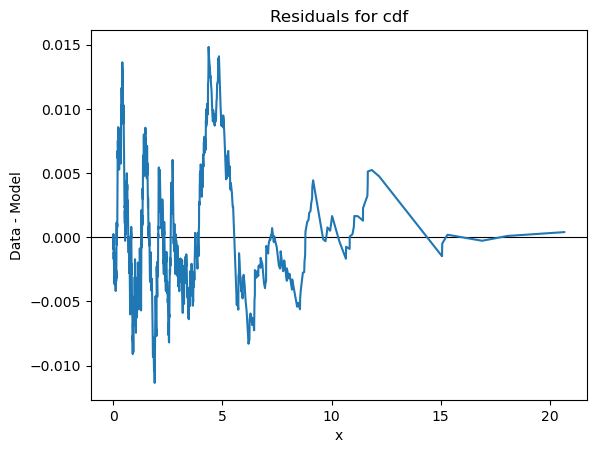

In [47]:
prefs = rplotcdf.plot_prefs
prefs['yerrorbars'] = False
prefs['marker'] = ''
prefs['linestyle'] = 'solid'
rplotcdf.plot()

Earlier I mentioned that the residual plot could be created manually from the data and model
plots. This is shown below, and only holds if the `prepare` method has been called on each
object.

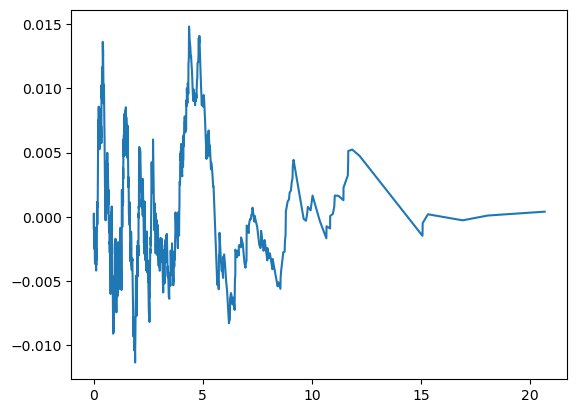

In [48]:
plt.plot(plotcdf.x, plotcdf.y - mplotcdf.y);

## Combining the fit and residual plots

I *can* use `matpotlib` commands to create a combined fit-and-residual plot (this time I
have to change the `clearwindow` option to `False` so that the subplots are not obliterated
by the `plot` method):

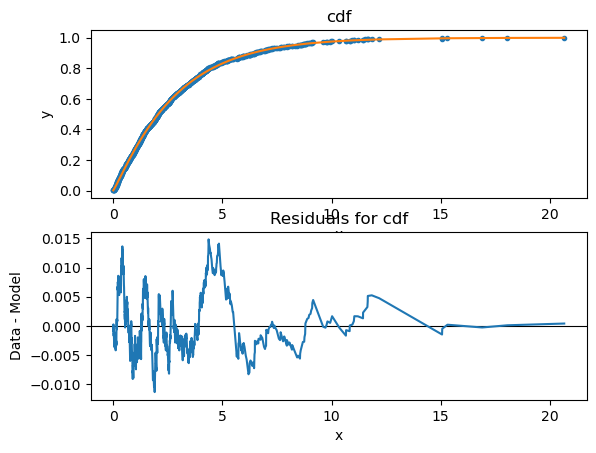

In [49]:
plt.subplot(2,1,1)
fplotcdf.plot(clearwindow=False)
plt.subplot(2,1,2)
rplotcdf.plot(clearwindow=False)

Perhaps unsurprisingly, given the presence of the `sherpa.ui.plot_fit_resid` function, Sherpa
provides a class to handle displays with multiple plots:

In [50]:
from sherpa.plot import SplitPlot

In [51]:
splot = SplitPlot()

Calling `addplot` with a plot object will add that plot in the next available element in the grid (which defaults to a 2-row, 1-column display).

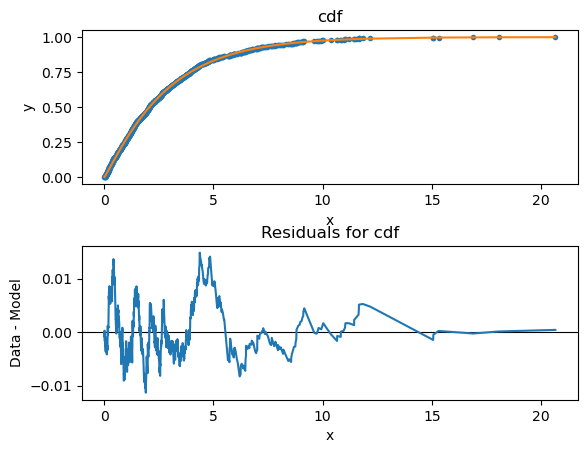

In [52]:
splot.addplot(fplotcdf)
splot.addplot(rplotcdf)

Larger grids can also be created, as shown below, but for that I need to create a residual plot of the "PDF" case:

In [53]:
rplotpdf = ResidPlot()
rplotpdf.prepare(dpdf, mpdf, Cash())
rplotpdf.plot_prefs['yerrorbars'] = False

Multiple data sets can be displayed. Here I chose to switch to a two-by-two grid
and plot up the data using the `plot` method which requires you to specify the column and
grid location of each plot (in this example I could have stuck with `addplot` since the order of the plots matches that used by `addplot`, but I wanted to show the direct approach here):

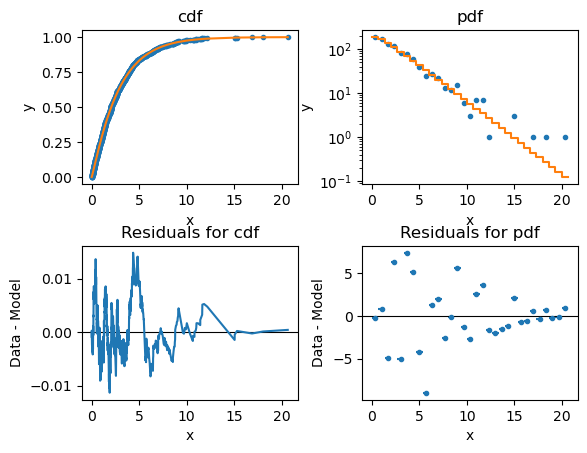

In [54]:
splot.reset(rows=2, cols=2)
splot.plot(0, 0, fplotcdf)
splot.plot(0, 1, fplotpdf)
splot.plot(1, 0, rplotcdf)
splot.plot(1, 1, rplotpdf)

Note that the two residual plots use different styles because of the different `plot_prefs` settings for each object.